# Robustness Test

In [ ]:
import os
# import cv2
import csv
# from tqdm import tqdm
import kornia as K
# import kornia.feature as KF
import kornia.morphology as morph
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import numpy as np
import torch
# import torch.nn.functional as F
# from kornia_moons.viz import draw_LAF_matches
# import skimage as ski
# from skimage import data, img_as_float
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import mean_squared_error
from IPython.display import clear_output, display, DisplayHandle

from loftr import loftr_match, tps_skimage
from utils import convert_image_to_tensor, affine, adjust_color, gaussian_blur, add_gaussian_noise, transform_img
from masking import fetch_leaves
from plotting import plot_image_pair, plot_match_coverage, plot_overlay
from metrics import mse, mse_masked, local_ncc, local_ncc_masked, nmi, nmi_masked, ssim_kornia, ssim_masked, iou, hausdorff
from DatasetTools.LeafImageSeries import LeafDataset
# from DatasetTools.LeafImageSeries import KeypointEditor

import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="monai"
)

## Loading Images

In [2]:
base_dir = '../leaf-image-sequences'
# base_dir = '../leaf-image-sequences-subset'
# base_dir = '../test-webdav-connection'
print(os.path.exists(base_dir))
print(os.path.exists(base_dir+'/raw'))

True
True


In [2]:
base_dir = '../leaf-image-sequences'
# base_dir = '../leaf-image-sequences-subset'
# base_dir = '../test-webdav-connection'
assert os.path.exists(base_dir), "Path to base directory invalid"
assert os.path.exists(base_dir+'/raw'), "Base directory empty"

leaf = LeafDataset(
    base_dir=base_dir,
    # leaf_uid="ESWW0090057_18", 
    leaf_uid="ESWW0070020_1", 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('images', 'rois', "keypoints"),
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...
Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading images...
Loading ROIs...
Loading keypoints...


In [3]:
available_data = {
            key: value for key, value in leaf.__dict__.items()
            if not key.startswith('_') and value is not None
        }
available_data.keys()

dict_keys(['base_dir', 'leaf_uid', 'series', 'image_uids', 'output_base', 'output_reg', 'output_ts', 'shift_affine', 'images', 'rois', 'keypoints'])

## Transformations

- rotation: 0 → ±30° (steps: 5°)
- translation: 0 → ±20% image width/height (steps: 5%)
- scale: 1.0 → 0.6–1.4 (steps: 0.1)
- brightness/contrast/gamma: 1.0 → [0.5, 1.5] (steps: 0.1)
- hue shift: 0 → ±0.1 (normalized) (steps: 0.02)
- saturation: 1.0 → [0.5, 1.5] (steps: 0.1)
- gaussian noise: σ = 0 → 0–25 (pixel value std, steps: 5)
- gaussian blur: kernel size 1 → 1,3,5,7
- ( jpeg quality: 100 → 100, 85, 60, 40, 20 )
- ( occlusion (cutout): occlusion area 0% → up to 40% of image (steps: 5–10%) )

In [4]:
transforms = {
    'Rotation': list(range(-30, 40, 10)),        # -30,...,-5,0,5,10,...,30 degrees
    'Translation': list(range(-20, 30, 10)),     # +/- 20% of image width/height
    'Scale': [0.5, 0.75, 1.25, 1.5], #list(range(0.5, 1.5, 0.25)),        # 0.5-1.5
    'Brightness': [0.1, 0.3, 0.5], #[0.0, 0.1, 0.2, 0.4, 0.5],    # 0 = no changes
    'Contrast': [0.8, 0.6], #[1.0, 0.9, 0.8, 0.7, 0.6],      # 1 = no changes, 0 = completely black
    'Gamma': [0.8, 1.0, 1.2], #[0.8, 0.9, 1.0, 1.1, 1.2],         # <1 -> dark regions lighter, >1 -> dark regions darker
    'Hue': [-0.05, 0.05],# list(range(-0.1, 0.1, 0.05)),       # 0 = no shift
    'Saturation': [0.75, 1.25],#list(range(0.5, 1.5, 0.1)),    # 1 = no changes, 0 = black&white, >1 = more saturated
    'Gaussian Noise': [0.5],#[0, 0.25, 0.5, 0.75, 1],           # 0 = no changes, higher = more noise
    'Gaussian Blur': [21, 51],#[11, 21, 51, 101, 151],
}
size_factors = [2]#[1, 2, 4, 8]
backgrounds = ["Eroded+Cropped"] #"Original", "Eroded", 
fixed_img_indices = [1]
moving_img_indices = [13, 3] #13

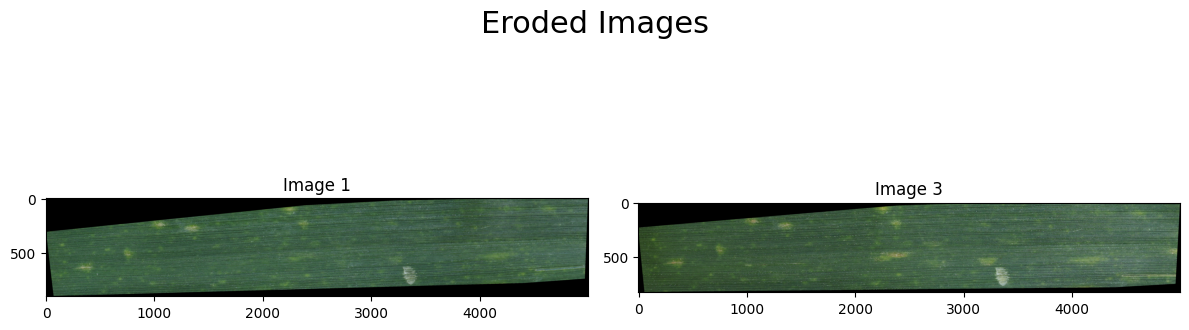

In [ ]:
fixed, moving = fetch_leaves([fixed_img_indices[0], moving_img_indices[-1]], leaf, background_type="Eroded+Cropped")
plot_image_pair(fixed, moving, fixed_img_indices[0], moving_img_indices[-1], title="Eroded Images")
plt.show()

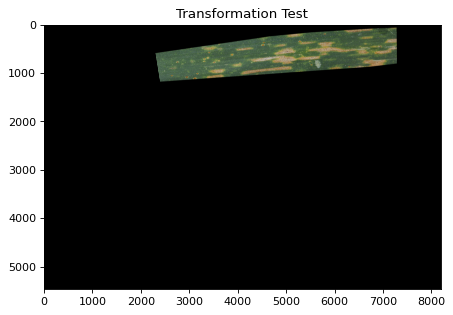

In [16]:
# trsf = K.augmentation.RandomAffine(30, (0.2, 0.2), (0.5, 1.5))
# test = trsf(moving_img)
test = affine(moving_img, 0, 0, -50, 1)
# test = adjust_color(moving_img, 1.5, 1.5)
# test = add_gaussian_noise(moving_img, sigma=0.5)
magnitude = 11
# test = K.filters.gaussian_blur2d(moving_img, kernel_size=torch.tensor([magnitude, magnitude]), sigma=torch.tensor([magnitude, magnitude]),)
# test= gaussian_blur(moving_img, kernel_size=magnitude, sigma=magnitude)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(test))
plt.title("Transformation Test")
plt.show()

## Evaluation

In [ ]:
out_file = "robustness_results2.csv"
thrsld = 0.5
file_exists = os.path.exists(out_file)

clear_output(wait=True)
handle = display(display_id=True)

metrics = {'MSE': mse, 'NCC': local_ncc, 'MI': nmi, 'SSIM': ssim_kornia}
# metrics = {'MSE': mse_masked, 'NCC': local_ncc_masked, 'MI': nmi_masked, 'SSIM': ssim_masked, 'IoU': iou, 'Hausdorff': hausdorff}

with open(out_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['fixed_image', 'moving_image', 'background', 'size','transform','magnitude','total_matches', 'conf_matches', 'inliers', 'mse', 'ssim', 'ncc', 'mi'])
    
    if not file_exists: # if file is new, write the header
        writer.writeheader()mas

    for fixed_img_ind in fixed_img_indices:
        for moving_img_ind in moving_img_indices:

            for background in backgrounds:
                fixed_img_full, moving_img_full = fetch_leaves([fixed_img_ind, moving_img_ind], leaf, background_type=background)

                if background == "Eroded+Cropped":
                    # cropped images are likely of different dimensions -> pad them to match
                    height = max(fixed_img_full.shape[-2], moving_img_full.shape[-2])
                    width = max(fixed_img_full.shape[-1], moving_img_full.shape[-1])

                    padder = K.augmentation.PadTo((height, width))

                    fixed_img_full = padder(fixed_img_full)
                    moving_img_full = padder(moving_img_full)
                else:
                    height = fixed_img_full.shape[-2]
                    width = fixed_img_full.shape[-1]

                for size_factor in size_factors:
                    H = int(height/size_factor)
                    W = int(width/size_factor)  
                    fixed_img = K.geometry.resize(fixed_img_full, (H, W), antialias=True)
                    moving_img = K.geometry.resize(moving_img_full, (H, W), antialias=True) 

                    # original images
                    
                    if background == "Original":
                        fig, _ = plot_image_pair(fixed_img, moving_img, fixed_img_ind, moving_img_ind, title=f"Original Images,   Size: 1/{size_factor}")
                        handle.update(fig)   
                        plt.close(fig)

                        mkpts0, mkpts1, confidence, _, n_matches = loftr_match(fixed_img, moving_img, verbose=False, return_n_matches=True)
                        
                        # TPS
                        warped, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, moving_img, verbose=True)
                        # mse_val = mean_squared_error(K.tensor_to_image(fixed_img), warped)
                        # ssim_val, _ = ssim(K.tensor_to_image(fixed_img), warped, channel_axis=-1, data_range=(warped.max() - warped.min()), full=True) 
                        # ncc_val = ncc(fixed_img, warped).item()
                        # mi_val = mutual_information(fixed_img, warped).item()

                        eval_res = {'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'background': background, 'size': f"1/{size_factor}", 'transform': None, 'magnitude': None, 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers']}

                        if (fixed_img is None) or (moving_img is None) or (fixed_mask is None) or (moving_mask is None):
                            print(f"Error: missing data for leaf {uid}")
                            for metric_name, metric_func in metrics.items():
                                eval_res.update({metric_name: None})    
                            writer.writerow(eval_res)
                            continue                    

                        # evaluate for all metrics
                        for metric_name, metric_func in metrics.items():
                            val = metric_func(fixed_img, warped)
                            # val = metric_func(fixed_img, fixed_mask, moving_img, moving_mask)
                            eval_res.update({metric_name: val.item()})

                        # write data to output
                        writer.writerow(eval_res)
                        
                        # writer.writerow({'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'background': background, 'size': f"1/{size_factor}", 'transform': None, 'magnitude': None, 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers'], 'mse': mse_val, 'ssim': ssim_val, 'ncc': ncc_val, 'mi': mi_val})
                        continue

                    for tname, magnitudes in transforms.items():
                        for mag in magnitudes:
                            transformed_img = transform_img(moving_img, tname, mag)

                            # plot current image pair
                            fig, _ = plot_image_pair(fixed_img, transformed_img, fixed_img_ind, moving_img_ind, title=f"Transform: {tname},  Magnitude: {mag},   Size: 1/{size_factor}")
                            handle.update(fig)   
                            plt.close(fig)

                            mkpts0, mkpts1, confidence, _, n_matches = loftr_match(fixed_img, transformed_img, verbose=False, return_n_matches=True)

                            # print(n_matches)
                            if n_matches['conf_matches'] > 3:
                                warped, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, transformed_img)
                                mse_val = mean_squared_error(K.tensor_to_image(fixed_img), warped)
                                ssim_val, _ = ssim(K.tensor_to_image(fixed_img), warped, channel_axis=-1, data_range=(warped.max() - warped.min()), full=True) 
                                ncc_val = ncc(fixed_img, warped).item()
                                mi_val = mutual_information(fixed_img, warped).item()
                            else:
                                print("No enough matches for TPS found")
                                mse_val = ssim_val = ncc_val = mi_val = None
                                
                            writer.writerow({'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'background': background, 'size': f"1/{size_factor}", 'transform': tname, 'magnitude': mag, 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers'], 'mse': mse_val, 'ssim': ssim_val, 'ncc': ncc_val, 'mi': mi_val})

No enough matches for TPS found
Not enough points to perform inlier detection.
No enough matches for TPS found
No enough matches for TPS found
Not enough points to perform inlier detection.
No enough matches for TPS found


### Verifiction

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /home/renku/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


100%|██████████| 44.2M/44.2M [00:00<00:00, 152MB/s] 


Total matches: 3133
Matches with Confidence > 0.5: 2341
Inliers: 712 (22.73%)


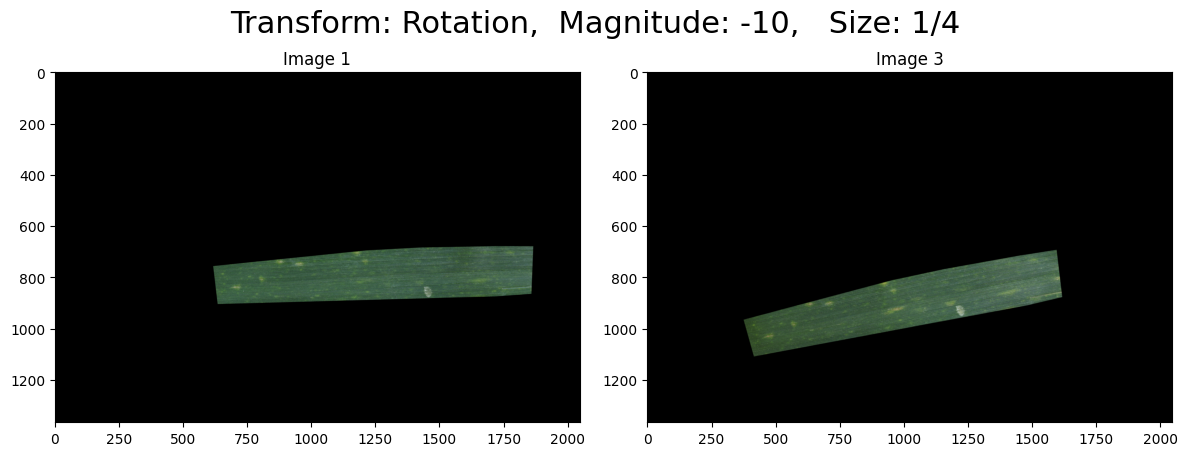

In [ ]:
transform = "Rotation"
magnitude = -10
size_factor = 4
background = "Eroded"
fixed_img_ind = 1
moving_img_ind = 3

fixed_img_full, moving_img_full = fetch_leaves([fixed_img_ind, moving_img_ind], leaf, background_type=background)

if background == "Eroded+Cropped":
    # cropped images are likely of different dimensions -> pad them to match
    height = max(fixed_img_full.shape[-2], moving_img_full.shape[-2])
    width = max(fixed_img_full.shape[-1], moving_img_full.shape[-1])

    padder = K.augmentation.PadTo((height, width))

    fixed_img_full = padder(fixed_img_full)
    moving_img_full = padder(moving_img_full)
else:
    height = fixed_img_full.shape[-2]
    width = fixed_img_full.shape[-1]


H = int(height/size_factor)
W = int(width/size_factor)  
fixed_img = K.geometry.resize(fixed_img_full, (H, W), antialias=True)
moving_img = K.geometry.resize(moving_img_full, (H, W), antialias=True)
transformed_img = transform_img(moving_img, transform, magnitude)

fig, _ = plot_image_pair(fixed_img, transformed_img, fixed_img_ind, moving_img_ind, title=f"Transform: {transform},  Magnitude: {magnitude},   Size: 1/{size_factor}")
fig.show()
mkpts0, mkpts1, confidence, inliers, n_matches = loftr_match(fixed_img, transformed_img, verbose=True, return_n_matches=True)

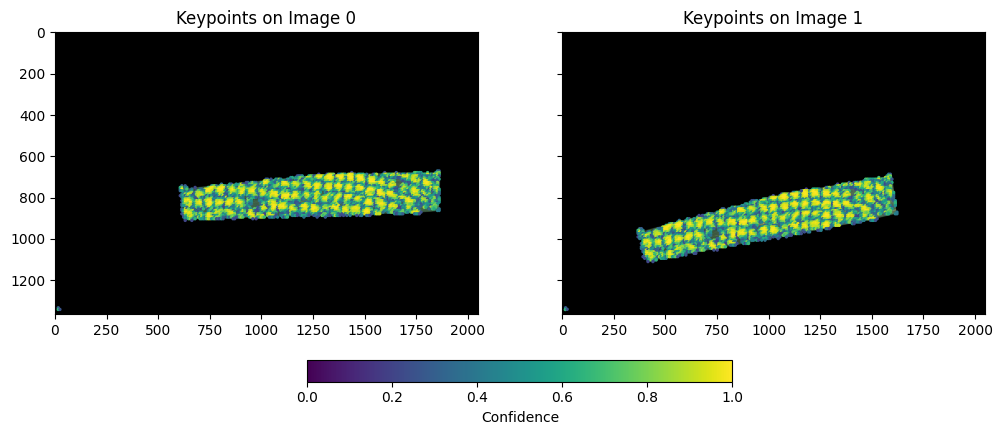

In [7]:
fig, _ = plot_match_coverage(fixed_img, mkpts0, transformed_img, mkpts1, confidence)
fig.show()

Setting threshold..
Threshold set to 0.95705032704
Estimating TPS transform...
Transforming moving image...


/home/renku/work/LeafAlignment/loftr.py:279: FutureWarning: `estimate` is deprecated since version 0.26 and will be removed in version 2.2. Please use `ThinPlateSplineTransform.from_estimate` class constructor instead.
  tps.estimate(img_fix_mks, img_mov_mks) # estimate transform from img_fix -> img_mov


-----------------------
Results:
fixed_image: 1, moving_image: 3, background: Eroded, size: 1/4, transform: Rotation, magnitude: -10
total_matches: 3133, conf_matches: 2341, inliers: 712
mse: 0.000468540971033509, ssim: 0.9485063552856445, ncc: 0.9727973341941833, mi: 0.28267985582351685


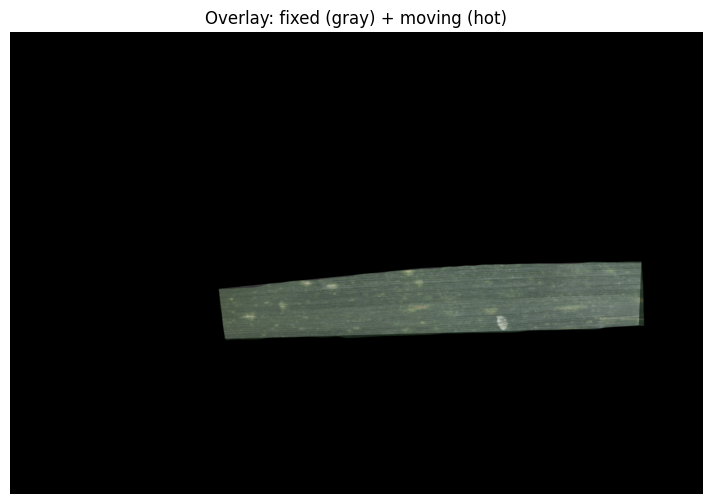

In [8]:
# TPS
thrsld = 0.5

warped, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, transformed_img, verbose=True)
mse_val = mean_squared_error(K.tensor_to_image(fixed_img), warped)
ssim_val, _ = ssim(K.tensor_to_image(fixed_img), warped, channel_axis=-1, data_range=(warped.max() - warped.min()), full=True) 
ncc_val = ncc(fixed_img, warped).item()
mi_val = mutual_information(fixed_img, warped).item()

print("-----------------------")
print("Results:")
print(f"fixed_image: {fixed_img_ind}, moving_image: {moving_img_ind}, background: {background}, size: 1/{size_factor}, transform: {transform}, magnitude: {magnitude}")
print(f"total_matches: {n_matches['total_matches']}, conf_matches: {int(n_matches['conf_matches'])}, inliers: {n_matches['inliers']}")
print(f"mse: {mse_val}, ssim: {ssim_val}, ncc: {ncc_val}, mi: {mi_val}")

fig = plot_overlay(fixed_img, warped)
fig.show()

# writer.writerow({'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'background': background, 'size': f"1/{size_factor}", 'transform': None, 'magnitude': None, 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers'], 'mse': mse_val, 'ssim': ssim_val, 'ncc': ncc_val, 'mi': mi_val})